In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.linear_solver import pywraplp
import random
import os

FRAC_ADMIT = 0.5


In [2]:


###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test.csv')
df['key'] = df['R'].astype(str) + "_"  + df['T'].astype(str)



In [3]:
df_train = pd.read_csv('./df_train.csv')
df_stratum_utility = df_train[['R','T','Y']].groupby(['R','T']).mean().reset_index()
df_stratum_utility['stratum_utility'] = df_stratum_utility['Y'] 
df_stratum_utility['key'] = df_stratum_utility['R'].astype(str) + "_" + df_stratum_utility['T'].astype(str)

df = df.merge(df_stratum_utility[['stratum_utility','key']], on='key')
df['ml_outcomes'] = df['stratum_utility']

In [4]:
FRAC_ADMIT = 0.25#df[['A']].sum()/len(df)


In [10]:
TOTAL_ADMITS = int(len(df)*FRAC_ADMIT)
MAX_BLACK_ADMITS = min(len(df[df['R']==1]), TOTAL_ADMITS)
MIN_GRADUATES = 10000
GRID_SIZE = 100

print(MAX_BLACK_ADMITS)

outcomes_grid = []
Xs = []
Ys = []

for N_black_admits in range(0,MAX_BLACK_ADMITS):
    
    if N_black_admits % GRID_SIZE != 0:
        continue
    
    black_admits = df[df['R']==1].sort_values(by='T',ascending=False).head(n=N_black_admits)
    white_admits = df[df['R']==0].sort_values(by='T',ascending=False).head(n=TOTAL_ADMITS-N_black_admits)
    
    Y = black_admits['Y'].sum() + white_admits['Y'].sum()
    
    Xs.append(N_black_admits)
    Ys.append(Y)
    print(N_black_admits,Y)
    
    for y_iter in np.arange(MIN_GRADUATES,Y,GRID_SIZE):
        outcomes_grid.append({'min_black_admits':N_black_admits-GRID_SIZE/2, 'max_black_admits':N_black_admits+GRID_SIZE/2, 'max_graduates':y_iter+GRID_SIZE, 'min_graduates':y_iter, 'policy_exists':'Unknown'})
        

25000
0 17873
100 17903
200 17936
300 17969
400 17989
500 18031
600 18058
700 18089
800 18102
900 18112
1000 18123
1100 18129
1200 18138
1300 18159
1400 18168
1500 18178
1600 18181
1700 18199
1800 18203
1900 18212
2000 18221
2100 18236
2200 18245
2300 18246
2400 18247
2500 18248
2600 18250
2700 18257
2800 18263
2900 18256
3000 18256
3100 18263
3200 18270
3300 18270
3400 18260
3500 18257
3600 18259
3700 18243
3800 18231
3900 18218
4000 18220
4100 18208
4200 18198
4300 18180
4400 18178
4500 18162
4600 18155
4700 18140
4800 18124
4900 18115
5000 18102
5100 18084
5200 18066
5300 18048
5400 18037
5500 18020
5600 18006
5700 17992
5800 17991
5900 17972
6000 17968
6100 17948
6200 17943
6300 17920
6400 17897
6500 17890
6600 17865
6700 17857
6800 17847
6900 17831
7000 17815
7100 17794
7200 17773
7300 17765
7400 17753
7500 17729
7600 17717
7700 17699
7800 17681
7900 17654
8000 17625
8100 17608
8200 17591
8300 17578
8400 17545
8500 17530
8600 17510
8700 17489
8800 17466
8900 17438
9000 17412
9100 

In [11]:
df_pareto = pd.DataFrame({'# Black Admits':Xs, '# Graduates':Ys})

dff = df[['R','T','Y']].groupby(['R','T']).count().reset_index()
dff.columns = ['R','T','N']
dff['key'] = dff['R'].astype(str) + "_" + dff['T'].astype(str)
dff2 = df[['R','T','Y']].groupby(['R','T']).mean().reset_index()
dff2.columns = ['R','T','Y']
dff2['key'] = dff['R'].astype(str) + "_" + dff['T'].astype(str)

dff = dff.merge(dff2[['key','Y']],on='key')

In [12]:
###
## Get boards passage probability in each stratum
###

df_prob = df[['R','T','Y']].groupby(['R','T']).mean().reset_index()
df_prob.columns = ['R','T','ml_outcomes_prob']
dff = dff.merge(df_prob[['ml_outcomes_prob']],left_index=True,right_index=True)


In [13]:
dff['Pr(X=X_j)'] = dff['N']/(dff['N']).sum()

In [19]:
df_decisions = None
max_utility = -1.0
solutions = 0

for C_y in np.linspace(0.0,1.0,1001):
    
    print(C_y)
    
    dff['alpha_j'] = dff['Pr(X=X_j)']* (dff['ml_outcomes_prob'] - C_y)
    solver = pywraplp.Solver.CreateSolver('GLOP')

    
    applicant_stratum = []
    vars_cache = {}
    alpha_j = {}
    
    # Objective: Maximize the expected utility of the admitted students
    objective = solver.Objective()
    
    # For each stratum
    for ix, row in dff.iterrows():
        # probability of admission
        numvar = solver.NumVar(0.0, 1.0, str(ix))
        
        # store variable by index, and also by stratum R, T
        applicant_stratum.append(numvar)
        vars_cache[(row['R'],row['T'])] = numvar
        
        alpha_j[(row['R'],row['T'])] = row['alpha_j']
        
        # Benefit of admitting people is total utility in that stratum
        objective.SetCoefficient(applicant_stratum[ix], float(row['N']))
        
    objective.SetMaximization()

    # Constraint: At most K applicants
    K = int(len(df)*FRAC_ADMIT)
    admit_quota = solver.Constraint(0, K)
    
    # Total admits cannot exceed K 
    for ix, row in dff.iterrows():
        admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))
    

    constrain_graduate = solver.Constraint(0, 0)
    
    for ix, row in dff.iterrows():
        
        key = (row['R'],row['T'])
        n_graduate = row['Y'] * row['N']
        constrain_graduate.SetCoefficient(vars_cache[key], float(n_graduate))
    
    constrain_black_admit = solver.Constraint(0, 0)
    
    for ix, row in dff.iterrows():
        key = (row['R'],row['T'])
        n_black = row['R'] * row['N']
        constrain_black_admit.SetCoefficient(vars_cache[key], float(n_black))

    
    
    sum_alpha = 0
    R = 1 
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_minority = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_minority.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )    
    
    sum_alpha = 0
    R = 0
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_majority = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_majority.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )
        
    count = 0 
    
    print ('Total grid cells to check: {}'.format(len(outcomes_grid)))
    
    for region in outcomes_grid:
        constrain_graduate.SetBounds(float(region['min_graduates']), float(region['max_graduates']))
        constrain_black_admit.SetBounds(float(region['min_black_admits']), float(region['max_black_admits']))
        status = solver.Solve()
        count+=1
        
        if count % 1000 ==0:
            print ('Total grid cells checked so far: {}/{}, Solutions: {}'.format(count,len(outcomes_grid),solutions))


        if status == 0:
            
            if region['policy_exists'] != 1:
                solutions+=1
            
            region['policy_exists'] = 1
            row = []
            admit = []
    
            for i in applicant_stratum:
                row.append(int(str(i)))
                admit.append(i.solution_value())
            #df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
            region['policy'] = (row,admit)    
        else:
            continue
            #print(status)
            



0.0
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.001
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solu

Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.01
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.02
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so f

Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.029
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.03
Total grid cells to c

Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.039
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.049
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.058
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so

Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.068
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.077
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.08700000000000001
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cel

Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.097
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.106
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so

Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.116
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.125
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.135
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.14400000000000002
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.145
Total 

Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.154
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.164
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.17300000000000001
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid c

Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.183
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.193
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.202
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.212
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.222
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.231
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.241
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.251
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.26
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so

Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.27
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so f

Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.28
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so f

Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.289
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so

Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.299
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.308
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.309
Total grid cells to 

Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.318
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.328
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.337
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.34700000000000003
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cel

Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.356
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.357
Total grid cells to 

Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.366
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.376
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.385
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked s

Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.395
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.405
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.41400000000000003
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid ce

Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 0
Total grid cells checked so far: 12000/14114, Solutions: 0
Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.424
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so 

Total grid cells checked so far: 13000/14114, Solutions: 0
Total grid cells checked so far: 14000/14114, Solutions: 0
0.433
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 0
Total grid cells checked so far: 2000/14114, Solutions: 0
Total grid cells checked so far: 3000/14114, Solutions: 0
Total grid cells checked so far: 4000/14114, Solutions: 0
Total grid cells checked so far: 5000/14114, Solutions: 0
Total grid cells checked so far: 6000/14114, Solutions: 0
Total grid cells checked so far: 7000/14114, Solutions: 0
Total grid cells checked so far: 8000/14114, Solutions: 0
Total grid cells checked so far: 9000/14114, Solutions: 0
Total grid cells checked so far: 10000/14114, Solutions: 0
Total grid cells checked so far: 11000/14114, Solutions: 1
Total grid cells checked so far: 12000/14114, Solutions: 1
Total grid cells checked so far: 13000/14114, Solutions: 1
Total grid cells checked so far: 14000/14114, Solutions: 1
0.434
Total grid cells to 

Total grid cells checked so far: 7000/14114, Solutions: 45
Total grid cells checked so far: 8000/14114, Solutions: 45
Total grid cells checked so far: 9000/14114, Solutions: 45
Total grid cells checked so far: 10000/14114, Solutions: 45
Total grid cells checked so far: 11000/14114, Solutions: 51
Total grid cells checked so far: 12000/14114, Solutions: 58
Total grid cells checked so far: 13000/14114, Solutions: 58
Total grid cells checked so far: 14000/14114, Solutions: 58
0.443
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 58
Total grid cells checked so far: 2000/14114, Solutions: 58
Total grid cells checked so far: 3000/14114, Solutions: 58
Total grid cells checked so far: 4000/14114, Solutions: 58
Total grid cells checked so far: 5000/14114, Solutions: 58
Total grid cells checked so far: 6000/14114, Solutions: 58
Total grid cells checked so far: 7000/14114, Solutions: 58
Total grid cells checked so far: 8000/14114, Solutions: 58
Total grid c

Total grid cells checked so far: 13000/14114, Solutions: 158
Total grid cells checked so far: 14000/14114, Solutions: 158
0.452
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 158
Total grid cells checked so far: 2000/14114, Solutions: 158
Total grid cells checked so far: 3000/14114, Solutions: 158
Total grid cells checked so far: 4000/14114, Solutions: 158
Total grid cells checked so far: 5000/14114, Solutions: 158
Total grid cells checked so far: 6000/14114, Solutions: 158
Total grid cells checked so far: 7000/14114, Solutions: 158
Total grid cells checked so far: 8000/14114, Solutions: 158
Total grid cells checked so far: 9000/14114, Solutions: 158
Total grid cells checked so far: 10000/14114, Solutions: 158
Total grid cells checked so far: 11000/14114, Solutions: 158
Total grid cells checked so far: 12000/14114, Solutions: 158
Total grid cells checked so far: 13000/14114, Solutions: 163
Total grid cells checked so far: 14000/14114, Solutions

Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.462
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 

Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.47100000000000003
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/1411

Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.48
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 

Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.489
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions

Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.499
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 

Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.508
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 

Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.517
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions

Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.527
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 

Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.536
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 

Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.545
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions:

Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.554
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions

Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.5640000000000001
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114

Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.5730000000000001
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114

Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.582
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions:

Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.591
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions

Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.601
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 

Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.61
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 1

Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.619
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions

Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.629
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 

Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.638
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 

Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.647
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions:

Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.656
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions

Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.666
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 

Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.675
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 

Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.684
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions

Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.6940000000000001
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114

Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.7030000000000001
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114

Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.712
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 

Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.721
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions

Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.731
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 

Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.74
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 1

Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.749
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions:

Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.758
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions

Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.768
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 

Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.777
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 

Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.786
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions

Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.796
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 

Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.805
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 

Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.8140000000000001
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/1411

Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.8230000000000001
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/141

Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.8320000000000001
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/141

Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.842
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 

Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.851
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 

Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.86
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions:

Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.87
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 1

Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.879
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 

Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.888
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions:

Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.897
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions

Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.907
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 

Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.916
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 

Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.925
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions

Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.935
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 

Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.9440000000000001
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114

Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.9530000000000001
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114

Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.962
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions

Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.972
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 

Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.981
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 

Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.99
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 

Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions: 166
0.999
Total grid cells to check: 14114
Total grid cells checked so far: 1000/14114, Solutions: 166
Total grid cells checked so far: 2000/14114, Solutions: 166
Total grid cells checked so far: 3000/14114, Solutions: 166
Total grid cells checked so far: 4000/14114, Solutions: 166
Total grid cells checked so far: 5000/14114, Solutions: 166
Total grid cells checked so far: 6000/14114, Solutions: 166
Total grid cells checked so far: 7000/14114, Solutions: 166
Total grid cells checked so far: 8000/14114, Solutions: 166
Total grid cells checked so far: 9000/14114, Solutions: 166
Total grid cells checked so far: 10000/14114, Solutions: 166
Total grid cells checked so far: 11000/14114, Solutions: 166
Total grid cells checked so far: 12000/14114, Solutions: 166
Total grid cells checked so far: 13000/14114, Solutions: 166
Total grid cells checked so far: 14000/14114, Solutions

## Add CF Predictive Parity Constraints

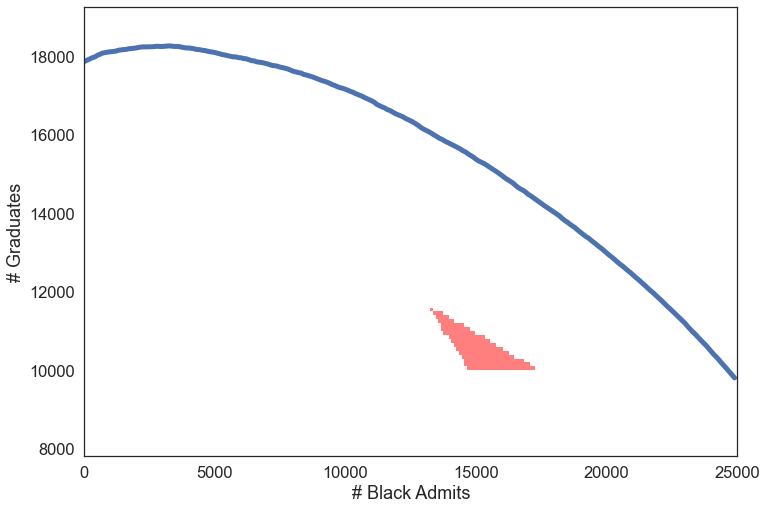

In [20]:
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="white", font_scale=1.5, )
ax = sns.lineplot(data=df_pareto, x='# Black Admits', y='# Graduates',linewidth=5)
errorboxes = []

for outcome_block in outcomes_grid:
    if outcome_block['policy_exists'] == 1:
        errorboxes.append(Rectangle((outcome_block['min_black_admits'] , outcome_block['min_graduates']),GRID_SIZE,GRID_SIZE))

pc = PatchCollection(errorboxes, facecolor='red', alpha=0.5,  edgecolor='none')
                       
ax.add_collection(pc)
plt.scatter(x=(df['R']*0.5).sum(),y=(df['Y']*0.5).sum(),color='green')   
plt.xlim([0, MAX_BLACK_ADMITS])
plt.ylim([df_pareto['# Graduates'].min()-2000, df_pareto['# Graduates'].max()+1000])
plt.show()


    
